In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Support JupyterThemes
jtplot.style()

import warnings
warnings.filterwarnings('ignore')

In [199]:
dataset = pd.read_csv("./input/train.csv")
survived = dataset[dataset['Survived'] == 1]
passing = dataset[dataset['Survived'] == 0]

Percentage of Class 1 that survived: 63.0 %
Percentage of Class 2 that survived: 47.0 %
Percentage of Class 3 that survived: 24.0 %


,1,2,3
Survived,136,87,119
Died,80,97,372


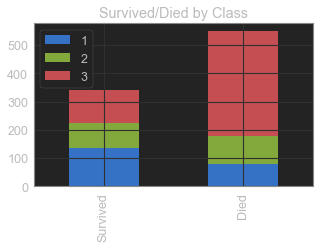

In [200]:
%matplotlib inline

#-------------------Survived/Died by Class -------------------------------------
survived_class = survived['Pclass'].value_counts()
dead_class = passing['Pclass'].value_counts()
df_class = pd.DataFrame([survived_class,dead_class])
df_class.index = ['Survived','Died']
df_class.plot(kind='bar',stacked=True, figsize=(5,3), title="Survived/Died by Class")

Class1_survived= df_class.iloc[0,0]/df_class.iloc[:,0].sum()*100
Class2_survived = df_class.iloc[0,1]/df_class.iloc[:,1].sum()*100
Class3_survived = df_class.iloc[0,2]/df_class.iloc[:,2].sum()*100
print("Percentage of Class 1 that survived:" ,round(Class1_survived),"%")
print("Percentage of Class 2 that survived:" ,round(Class2_survived), "%")
print("Percentage of Class 3 that survived:" ,round(Class3_survived), "%")

# display table
from IPython.display import display
display(df_class)

Male:  19.0 %
Female:  74.0 %


,female,male
Survived,233,109
Passed,81,468


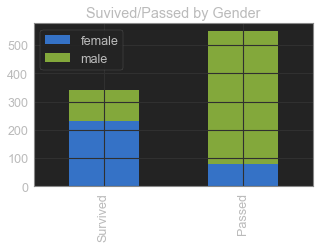

In [201]:
survived_gender = survived['Sex'].value_counts()
passing_gender = passing['Sex'].value_counts()

df_gender = pd.DataFrame([survived_gender, passing_gender])
df_gender.index = ['Survived', 'Passed']
df_gender.plot(kind='bar', stacked=True, figsize=(5,3), title="Suvived/Passed by Gender")

male_survival = df_gender.iloc[0, 1] / df_gender.iloc[:, 1].sum() * 100
female_survival = df_gender.iloc[0, 0] / df_gender.iloc[:, 0].sum() * 100

print("Male: ", round(male_survival), "%")
print("Female: ", round(female_survival), "%")

display(df_gender)

In [202]:
def developFeatures( inputset ):
    inputset['Salutation'] = inputset['Name'].apply(lambda x: re.search('[A-Z][a-z]*\.|$', x).group(0)).astype('category')
    inputset['Sex'] = inputset['Sex'].astype('category')
    inputset['Embarked'] = inputset['Embarked'].interpolate(method='pad').astype('category')
    return inputset

dataset = developFeatures(dataset)
ages = round(dataset.groupby(['Salutation'])['Age'].mean())
display(ages)

Salutation
Capt.        70.0
Col.         58.0
Countess.    33.0
Don.         40.0
Dr.          42.0
Jonkheer.    38.0
Lady.        48.0
Major.       48.0
Master.       5.0
Miss.        22.0
Mlle.        24.0
Mme.         24.0
Mr.          32.0
Mrs.         36.0
Ms.          28.0
Rev.         43.0
Sir.         49.0
Name: Age, dtype: float64

In [203]:
def fillEstimatedAge( inputset ):
    inputset['Age'] = inputset.apply(lambda row: ages[row['Salutation']] if np.isnan(row['Age']) else row['Age'], axis=1)
    return inputset

dataset = fillEstimatedAge(dataset)

survival = dataset.groupby(['Survived'])
survival_by_gender = dataset.groupby(['Sex', 'Survived']).agg({'Sex': 'count'})
percentages = survival_by_gender.apply(lambda x: 100 * x / float(x.sum()))
print(percentages)

                       Sex
Sex    Survived           
female 0          9.090909
       1         26.150393
male   0         52.525253
       1         12.233446


In [204]:
# Balance Data
# passed, survived = dataset.groupby(['Survived'])

# sample_passed = passed[1].sample(len(survived[1].index))

# dataset = sample_passed.append(survived[1])

# print('Balancing = Survived: %0.2f, Passed: %0.2f' % (len(survived[1].index) / len(dataset.index), len(sample_passed.index) / len(dataset.index)))

In [205]:
from sklearn import preprocessing
normaliser = preprocessing.MinMaxScaler()

# Remove problematic columns for now
X = dataset.drop(columns=['Name', 'Ticket', 'Cabin']).iloc[:, 2:]
y = dataset.iloc[:, 1]

# Convert categories to numbers
def prepareNominalValues( inputset ):   
    categories = inputset.select_dtypes(['category']).columns
    inputset[categories] = inputset[categories].apply(lambda x: x.cat.codes)
    return inputset

X = prepareNominalValues(X)

# Select Best Features
selector = SelectKBest(score_func=chi2, k=4)
X_r = selector.fit_transform(X, y)
X_n = normaliser.fit_transform(selector.fit_transform(X, y))

featList = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(selector.scores_)], axis=1)
featList.columns = ['Feature', 'Score']

featuresSortedByScore = featList.sort_values(by='Score', ascending=False)
display(featuresSortedByScore)

topFeats = featuresSortedByScore.iloc[:4, 0].values
display(topFeats);

,Feature,Score
5,Fare,4518.319091
1,Sex,92.702447
2,Age,39.609709
0,Pclass,30.873699
7,Salutation,11.183332
6,Embarked,10.893210
4,Parch,10.097499
3,SibSp,2.581865


array(['Fare', 'Sex', 'Age', 'Pclass'], dtype=object)

In [210]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

# Create Classifier Instance
gnb = GaussianNB()
gnb.fit(X=X_r, y=y)

def calculate_metrics(classifier):
    scores = cross_val_score(classifier, X_r, y, cv=10)
    display("Cross V: %0.2f %% (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    predictions = classifier.predict(X_r)
    tn, fp, fn, tp = metrics.confusion_matrix(y, predictions).ravel()
    matrix = pd.DataFrame(data=[[tn, fn], [fp, tp]], index=['+', '-'], columns=['True', 'False'])
    display(matrix)
    
    pr, rc, fs, sp = metrics.precision_recall_fscore_support(y, predictions, average='binary')
    display(pd.DataFrame(data=[pr, rc, fs], index=['Precision', 'Recall', 'FScore'], columns=['Score']).apply(lambda val: round(val * 100, 1)))
    
calculate_metrics(gnb)

'Cross V: 0.78 % (+/- 0.04)'

,True,False
+,446,95
-,103,247


,Score
Precision,70.6
Recall,72.2
FScore,71.4


'Cross V: 0.80 % (+/- 0.06)'

,True,False
+,492,100
-,57,242


,Score
Precision,80.9
Recall,70.8
FScore,75.5


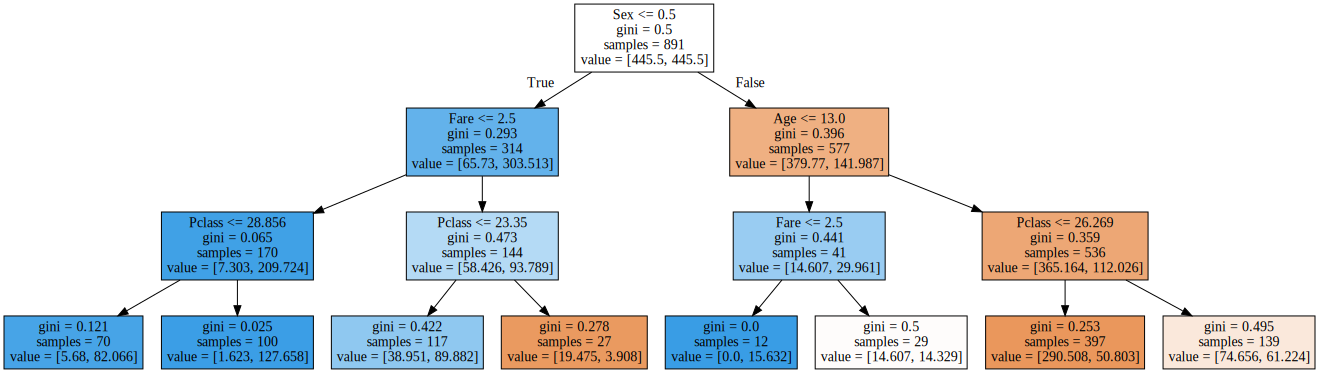

In [221]:
from IPython.display import SVG
from sklearn import tree
from graphviz import Source

decTree = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.01, min_samples_split=0.01, class_weight='balanced')
decTree.fit(X=X_r, y=y)

calculate_metrics(decTree)

graph = Source(tree.export_graphviz(decTree, out_file=None, feature_names=topFeats, filled = True));
display(SVG(graph.pipe(format='svg')))

In [211]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.1, fit_intercept=True, dual=True, class_weight='balanced')
lsvc.fit(X=X_r, y=y)

calculate_metrics(lsvc)

'Cross V: 0.77 % (+/- 0.08)'

,True,False
+,459,101
-,90,241


,Score
Precision,72.8
Recall,70.5
FScore,71.6


In [213]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X=X_r, y=y)

calculate_metrics(knc)

'Cross V: 0.69 % (+/- 0.07)'

,True,False
+,547,140
-,2,202


,Score
Precision,99.0
Recall,59.1
FScore,74.0


In [214]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')
svc.fit(X=X_r, y=y)

calculate_metrics(svc)

'Cross V: 0.71 % (+/- 0.09)'

,True,False
+,489,34
-,60,308


,Score
Precision,83.7
Recall,90.1
FScore,86.8


In [215]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=35, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, class_weight='balanced')
rfc.fit(X=X_r, y=y)

calculate_metrics(rfc)

'Cross V: 0.77 % (+/- 0.07)'

,True,False
+,468,109
-,81,233


,Score
Precision,74.2
Recall,68.1
FScore,71.0


In [216]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X=X_r, y=y)

calculate_metrics(logreg)

'Cross V: 0.78 % (+/- 0.03)'

,True,False
+,436,81
-,113,261


,Score
Precision,69.8
Recall,76.3
FScore,72.9


In [222]:
# Create predictions on test data
testrawset = pd.read_csv("./input/test.csv")

testset = prepareNominalValues(fillEstimatedAge(developFeatures(testrawset))).drop(columns=['Name', 'Ticket', 'Cabin']).iloc[:, 1:].fillna(0)
testset = selector.transform(testset)

testPrediction = decTree.predict(testset)

output = testrawset.loc[:, ['PassengerId']]
output.insert(loc=1, column='Survived', value=testPrediction)

testcsv = output.to_csv(path_or_buf=r'./output/decisionTreeD3CWB.csv', index=False)
